# 🧠 RNNs as Computational Dynamical Systems

## Tutorial Introduction

**Welcome!** In this tutorial, we'll explore recurrent neural networks (RNNs) through the powerful lens of dynamical systems theory. We'll understand them as dynamical systems that can be analyzed, visualized, and compared to their biological counterparts.

### What You'll Learn
1. **RNNs = Dynamical Systems**: How to formulate RNNs as continuous-time ODEs
2. **The Lorenz System**: Our benchmark chaotic system for testing
3. **Biological Constraints**: E/I balance, Dale's law, spiking neurons
4. **Analysis Tools**: Fixed points, Lyapunov exponents, attractor geometry

### Tutorial Structure

| Notebook | Content | Duration |
|----------|---------|----------|
| **00** | Introduction, Lorenz system, setup | 30 min |
| **01** | Continuous-Time RNN | 45 min |
| **02** | Balanced E/I Rate Network | 45 min |
| **03** | Balanced Spiking Network | 45 min |
| **04** | Dynamical Systems Analysis | 30 min |
| **05** | Synthesis & Comparison | 30 min |

---
## 🚀 Setup

First, let's install dependencies and set up our environment.

In [10]:
# Install dependencies (run this cell on Colab)
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install -q torch torchdiffeq norse matplotlib scipy tqdm
    
    # Clone the tutorial repository
    !git clone -q https://github.com/CNNC-Lab/RNNs-tutorial.git
    %cd RNNs-tutorial

# Import from src/
from src import setup_environment, check_dependencies
from src.data import generate_lorenz_trajectory

check_dependencies()
device = setup_environment()

✓ All dependencies installed
✓ Environment ready. Using device: cpu


In [11]:
# Additional imports for this notebook
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp

# Note: Random seeds and plotting style are set by setup_environment()
print(f"Using device: {device}")

Using device: cpu


---
## 📐 Part 1: RNNs as Dynamical Systems

### The Key Insight

A recurrent neural network can be written as a **discrete-time dynamical system**:

$$\mathbf{h}_{t+1} = f(\mathbf{h}_t, \mathbf{x}_t; \theta)$$

Or equivalently, as a **continuous-time dynamical system**:

$$\tau \frac{d\mathbf{h}}{dt} = -\mathbf{h} + \phi(\mathbf{W}_{rec}\mathbf{h} + \mathbf{W}_{in}\mathbf{x} + \mathbf{b})$$

This formulation lets us use powerful tools from dynamical systems theory:

- **Fixed points**: Where $\frac{d\mathbf{h}}{dt} = 0$
- **Stability analysis**: Eigenvalues of the Jacobian
- **Attractors**: Stable patterns the system converges to
- **Lyapunov exponents**: Measure of chaos

### Why This Perspective Matters

1. **Interpretability**: We can understand *what* the network has learned in terms of attractor landscapes
2. **Comparison to biology**: Neural circuits are continuous-time dynamical systems
3. **Universal approximation**: RNNs can approximate any dynamical system (given enough capacity)
4. **Analysis tools**: We can find fixed points, bifurcations, and chaos signatures

---
## 🦋 Part 2: The Lorenz System — Our Benchmark

The [Lorenz system](https://en.wikipedia.org/wiki/Lorenz_system) is a classic chaotic dynamical system that will serve as our ground truth throughout this tutorial. It was discovered by Edward Lorenz in 1963 while studying atmospheric convection.

### The Equations

$$\frac{dx}{dt} = \sigma(y - x)$$
$$\frac{dy}{dt} = x(\rho - z) - y$$
$$\frac{dz}{dt} = xy - \beta z$$

With standard parameters: $\sigma = 10$, $\rho = 28$, $\beta = 8/3$

### Key Properties

- **Chaotic**: Sensitive dependence on initial conditions
- **Strange attractor**: The famous "butterfly" shape
- **Dissipative**: Volume in phase space contracts
- **Low-dimensional**: Only 3 state variables

In [12]:
# The Lorenz system is now defined in src.data.lorenz_system
# We can import and use it here for demonstration

from src.data import lorenz_system

# Let's see the function signature
print("Lorenz system function:")
print(lorenz_system.__doc__)

Lorenz system function:

    Lorenz-63 system of ODEs.
    
    dx/dt = σ(y - x)
    dy/dt = x(ρ - z) - y
    dz/dt = xy - βz
    
    Parameters
    ----------
    t : float
        Time (not used, but required by solve_ivp)
    state : np.ndarray
        Current state [x, y, z]
    sigma : float
        Prandtl number (default: 10)
    rho : float
        Rayleigh number (default: 28)
    beta : float
        Geometric factor (default: 8/3)
        
    Returns
    -------
    np.ndarray
        Derivatives [dx/dt, dy/dt, dz/dt]
    


In [13]:
# Generate a Lorenz trajectory using src.data module
from src.data import generate_lorenz_trajectory

t, trajectory = generate_lorenz_trajectory(
    t_span=(0, 100),
    dt=0.01,
    seed=42,
    transient=10.0
)

print(f"Generated trajectory: {trajectory.shape[0]} time points, {trajectory.shape[1]} dimensions")
print(f"Time step: {t[1] - t[0]:.4f}")

Generated trajectory: 10000 time points, 3 dimensions
Time step: 0.0100


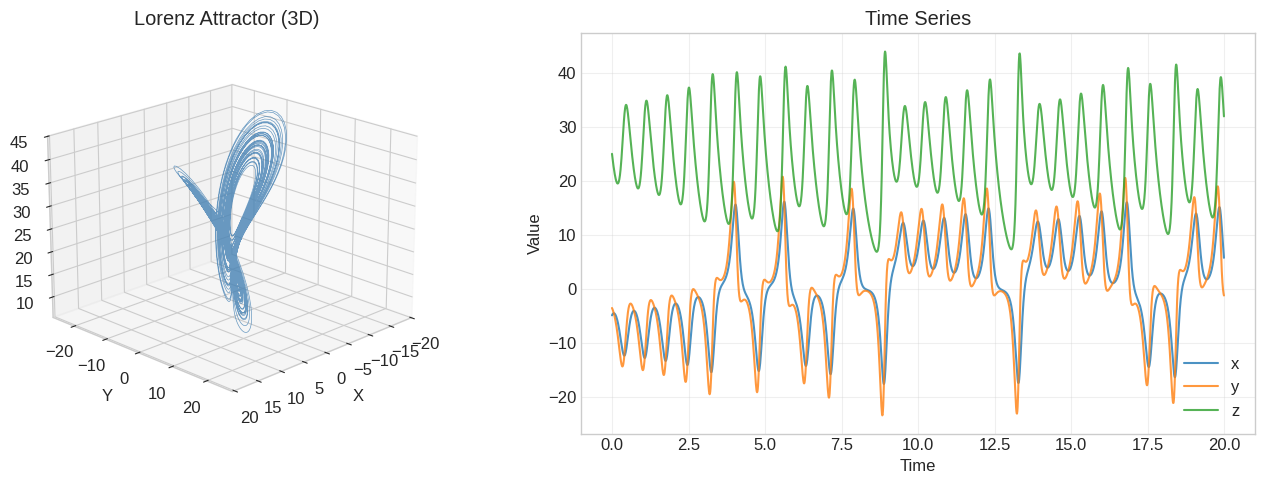

In [14]:
# Visualize the Lorenz attractor using src.utils
from src.utils import plot_lorenz_intro

fig = plot_lorenz_intro(trajectory, t)
plt.show()

### 🔍 Explore: Sensitivity to Initial Conditions

A hallmark of chaotic systems is **sensitive dependence on initial conditions** — tiny differences grow exponentially. Let's visualize this.

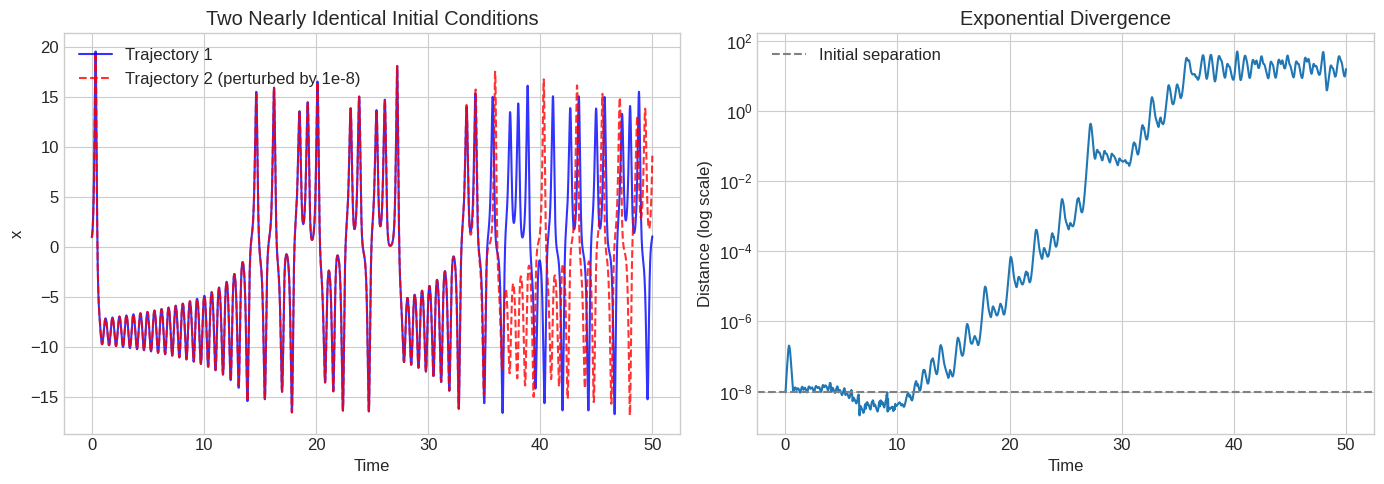

Initial separation: 1e-08
Final separation: 15.74
Amplification factor: 1.57e+09


In [15]:
# Two trajectories with slightly different initial conditions
ic1 = [1.0, 1.0, 1.0]
ic2 = [1.0 + 1e-8, 1.0, 1.0]  # Tiny perturbation!

sol1 = solve_ivp(lorenz_system, (0, 50), ic1, t_eval=np.linspace(0, 50, 5000))
sol2 = solve_ivp(lorenz_system, (0, 50), ic2, t_eval=np.linspace(0, 50, 5000))

# Compute distance between trajectories
distance = np.sqrt(np.sum((sol1.y - sol2.y)**2, axis=0))

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Trajectories
axes[0].plot(sol1.t, sol1.y[0], 'b-', label='Trajectory 1', alpha=0.8)
axes[0].plot(sol2.t, sol2.y[0], 'r--', label='Trajectory 2 (perturbed by 1e-8)', alpha=0.8)
axes[0].set_xlabel('Time')
axes[0].set_ylabel('x')
axes[0].set_title('Two Nearly Identical Initial Conditions')
axes[0].legend()

# Distance (log scale)
axes[1].semilogy(sol1.t, distance)
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Distance (log scale)')
axes[1].set_title('Exponential Divergence')
axes[1].axhline(1e-8, color='gray', ls='--', label='Initial separation')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"Initial separation: {1e-8:.0e}")
print(f"Final separation: {distance[-1]:.2f}")
print(f"Amplification factor: {distance[-1]/1e-8:.2e}")

### 🎯 Our Task: Lorenz Trajectory Prediction

**Goal**: Train an RNN to predict the next state of the Lorenz system given its current state.

$$\hat{\mathbf{s}}_{t+\Delta t} = \text{RNN}(\mathbf{s}_t)$$

where $\mathbf{s} = [x, y, z]^T$.

This is interesting because:
1. The dynamics are highly nonlinear
2. Long-term prediction is fundamentally limited by chaos
3. We can analyze what the trained RNN has learned

---
## 📊 Part 3: Preparing the Data

Let's create training, validation, and test sets from our Lorenz trajectory.

In [16]:
# Generate and save the dataset that will be used across all notebooks
from src.data import save_lorenz_dataset, generate_lorenz_trajectory
import numpy as np

print("Generating Lorenz trajectories for train/val/test...")

# Generate training trajectory (140 seconds)
t_train, traj_train = generate_lorenz_trajectory(
    t_span=(0, 140), dt=0.01, seed=42, transient=10.0
)

# Generate validation trajectory (30 seconds)
t_val, traj_val = generate_lorenz_trajectory(
    t_span=(0, 30), dt=0.01, seed=43, transient=10.0
)

# Generate test trajectory (30 seconds)  
t_test, traj_test = generate_lorenz_trajectory(
    t_span=(0, 30), dt=0.01, seed=44, transient=10.0
)

print(f"✓ Train: {traj_train.shape}")
print(f"✓ Val: {traj_val.shape}")
print(f"✓ Test: {traj_test.shape}")

# Compute normalization parameters from training data only
mean = traj_train.mean(axis=0)
std = traj_train.std(axis=0)

print(f"\nNormalization (computed from training set):")
print(f"  Mean: {mean}")
print(f"  Std: {std}")

# Normalize all splits using training statistics
train_norm = (traj_train - mean) / std
val_norm = (traj_val - mean) / std
test_norm = (traj_test - mean) / std

# Save the preprocessed data
save_lorenz_dataset(
    filepath='../data/processed/lorenz_data.npz',
    train_data=train_norm,
    val_data=val_norm,
    test_data=test_norm,
    normalization_params={'mean': mean, 'std': std},
    metadata={'dt': 0.01, 'seq_length': 50}
)

print("\n✅ Saved to: ../data/processed/lorenz_data.npz")
print("   This shared dataset will be used by notebooks 01-05.")

Generating Lorenz trajectories for train/val/test...
✓ Train: (14000, 3)
✓ Val: (3000, 3)
✓ Test: (3000, 3)

Normalization (computed from training set):
  Mean: [-0.76262796 -0.75006465 23.46947626]
  Std: [7.86860479 8.99086565 8.66683304]
✓ Dataset saved to ../data/processed/lorenz_data.npz
  Train: (14000, 3), Val: (3000, 3), Test: (3000, 3)

✅ Saved to: ../data/processed/lorenz_data.npz
   This shared dataset will be used by notebooks 01-05.


### Data Generation Complete!

We've created a **shared dataset** that will be used throughout the tutorial:

✅ **Generated** separate Lorenz trajectories for train/val/test  
✅ **Normalized** using training set statistics  
✅ **Saved** to `../data/processed/lorenz_data.npz`

**All subsequent notebooks (01-05) will load this exact same data**, ensuring:
- Consistent comparisons between architectures
- No duplication of data generation code  
- Reproducible results across the tutorial

Let's now demonstrate how to load this data and create DataLoaders...

Loading saved dataset and creating DataLoaders...
✓ Dataset loaded from ../data/processed/lorenz_data.npz
  Train: (14000, 3), Val: (3000, 3), Test: (3000, 3)
  dt=0.01, seq_length=50

Dataset info:
  Train samples: 13950
  Val samples: 2950
  Test samples: 2950
  Sequence length: 50
  Time step (dt): 0.01

Batch shapes:
  Input: torch.Size([64, 50, 3])  # (batch_size, seq_length, input_dim)
  Target: torch.Size([64, 3])  # (batch_size, output_dim)


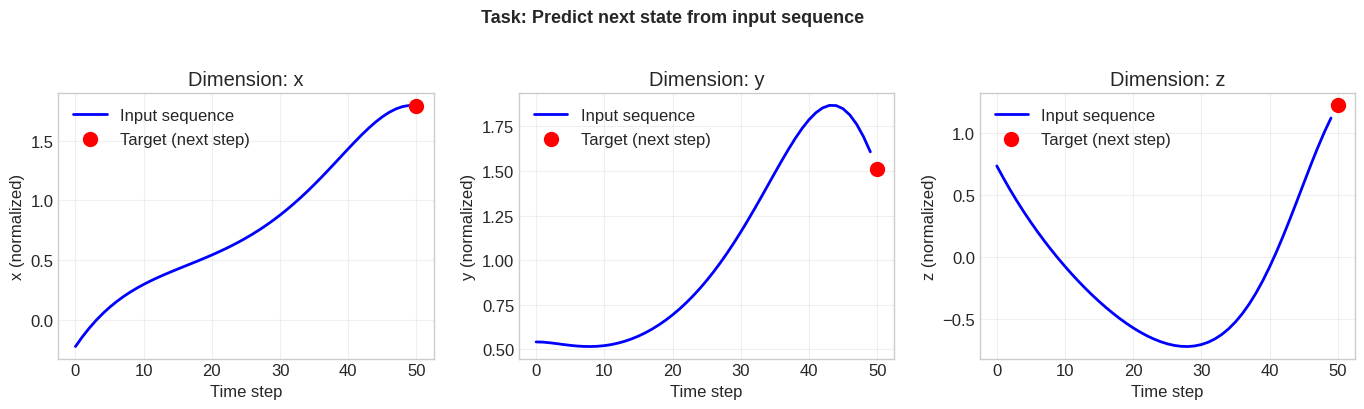

In [17]:
# Load the saved data and create DataLoaders
# This is what notebooks 01-05 will do!
from src.data import create_shared_dataloaders

print("Loading saved dataset and creating DataLoaders...")
train_loader, val_loader, test_loader, info = create_shared_dataloaders(
    dataset_path='../data/processed/lorenz_data.npz',
    batch_size=64,
    seq_length=50
)

print(f"\nDataset info:")
print(f"  Train samples: {info['train_samples']}")
print(f"  Val samples: {info['val_samples']}")
print(f"  Test samples: {info['test_samples']}")
print(f"  Sequence length: {info['seq_length']}")
print(f"  Time step (dt): {info['dt']}")

# Visualize a sample from the DataLoader
sample_x, sample_y = next(iter(train_loader))

print(f"\nBatch shapes:")
print(f"  Input: {sample_x.shape}  # (batch_size, seq_length, input_dim)")
print(f"  Target: {sample_y.shape}  # (batch_size, output_dim)")

# Visualize one sample
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
seq_length = sample_x.shape[1]

for i, (ax, dim) in enumerate(zip(axes, ['x', 'y', 'z'])):
    ax.plot(range(seq_length), sample_x[0, :, i].numpy(), 'b-', label='Input sequence', linewidth=2)
    ax.scatter([seq_length], [sample_y[0, i].numpy()], c='red', s=100, zorder=5, label='Target (next step)')
    ax.set_xlabel('Time step')
    ax.set_ylabel(f'{dim} (normalized)')
    ax.legend()
    ax.set_title(f'Dimension: {dim}')
    ax.grid(True, alpha=0.3)

plt.suptitle('Task: Predict next state from input sequence', y=1.02, fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

**Implementation Note**: The `LorenzDataset` class, data preprocessing, and persistence functions are all provided by the `src.data` module. This modular design:
- ✅ Reduces code duplication across notebooks
- ✅ Ensures consistent data handling  
- ✅ Makes the tutorial easier to maintain

See [src/data/__init__.py](../src/data/__init__.py) for the implementation details.

---

---
## 🧪 Part 4: Preview — The Networks We'll Build

Over the next notebooks, we'll implement and compare three network architectures:

### 1. Continuous-Time RNN (CT-RNN)
$$\tau \frac{d\mathbf{h}}{dt} = -\mathbf{h} + \tanh(\mathbf{W}_{rec}\mathbf{h} + \mathbf{W}_{in}\mathbf{x} + \mathbf{b})$$

- Smooth dynamics
- Amenable to ODE analysis
- Trained using Neural ODEs (adjoint method)

### 2. Balanced E/I Rate Network
$$\tau_E \frac{d\mathbf{r}_E}{dt} = -\mathbf{r}_E + \phi(\mathbf{W}_{EE}\mathbf{r}_E - \mathbf{W}_{EI}\mathbf{r}_I + \mathbf{I}_{ext})$$
$$\tau_I \frac{d\mathbf{r}_I}{dt} = -\mathbf{r}_I + \phi(\mathbf{W}_{IE}\mathbf{r}_E - \mathbf{W}_{II}\mathbf{r}_I)$$

- Separate excitatory (E) and inhibitory (I) populations
- Dale's law: E neurons have positive weights, I neurons have negative
- Dynamically balanced regime

### 3. Balanced Spiking Network
$$\tau_m \frac{dV}{dt} = -(V - V_{rest}) + I_{syn} + I_{ext}$$
$$\text{if } V > V_{th}: \text{spike}, V \rightarrow V_{reset}$$

- Leaky Integrate-and-Fire (LIF) neurons
- Event-driven communication (spikes)
- Reservoir computing approach

---
## 📋 Summary & Next Steps

The shared dataset is now ready at `../data/processed/lorenz_data.npz`!

**In Notebooks 01-05**, you'll load this data with just two lines:

```python
from src.data import create_shared_dataloaders
train_loader, val_loader, test_loader, info = create_shared_dataloaders()
```

This ensures all architectures are trained and compared on **exactly the same data**.

### 🎯 You're Ready!

Proceed to the next notebooks to build and train RNN architectures:

1. **Notebook 01**: Continuous-Time RNN with Neural ODEs
2. **Notebook 02**: Balanced E/I Rate Network  
3. **Notebook 03**: Balanced Spiking Network
4. **Notebook 04**: Dynamical Systems Analysis
5. **Notebook 05**: Architecture Comparison & Synthesis

Each notebook will automatically load the shared Lorenz dataset you just created. Happy learning! 🚀